# CORD-19 Research Dataset: Analysis & Visualization

In [ ]:
import ipywidgets as widgets
from IPython.display import display,HTML,clear_output
with open('/kaggle/input/cleaned-medical-ner-graph/widget.html', 'r') as content_file:
    content = content_file.read()
    display(HTML(content))


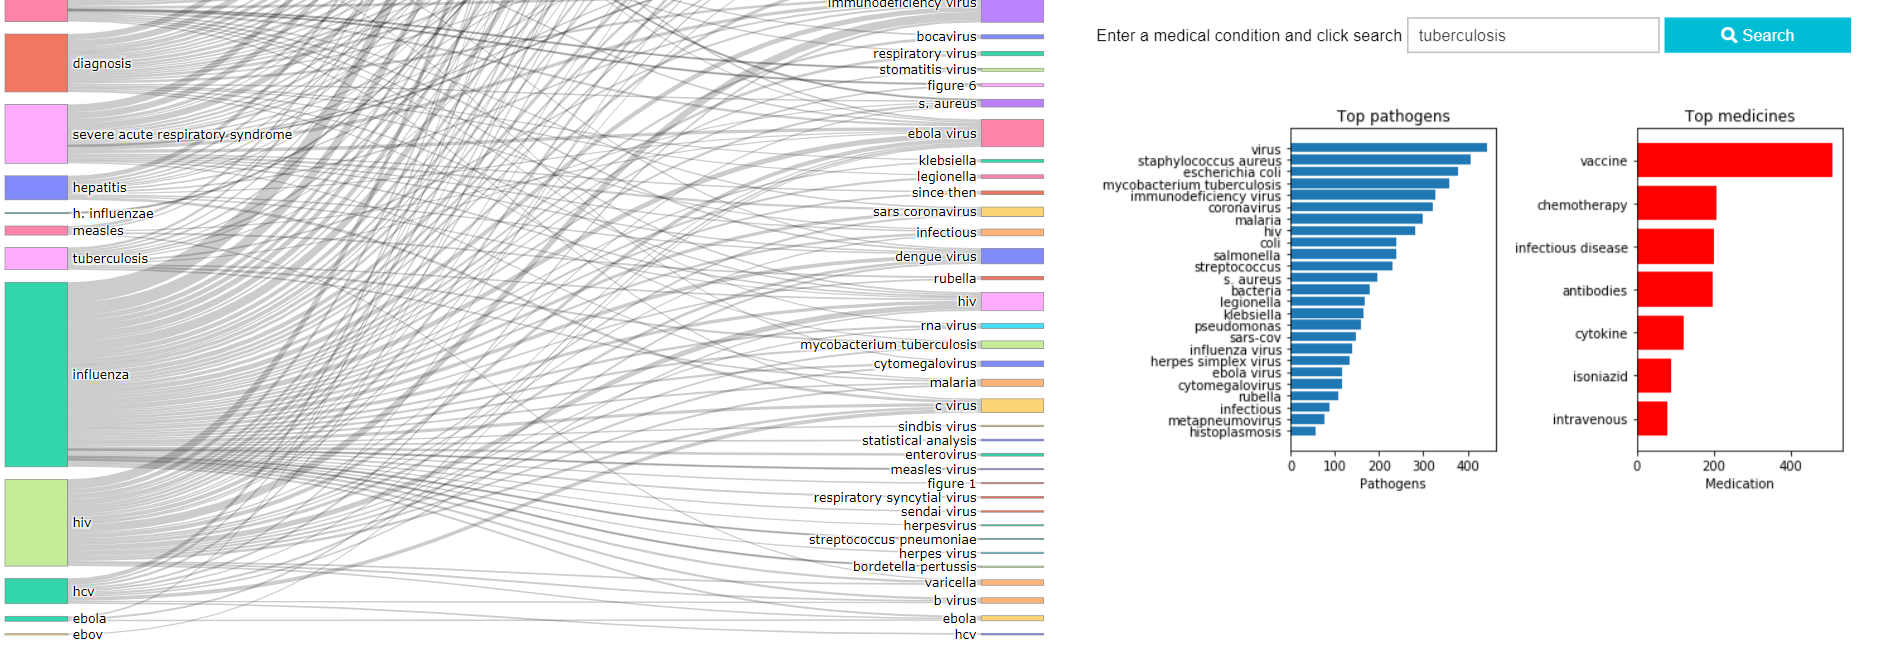

> This is still a working draft. Expect dirty code, imcomplete documention and changes every now and then :-)

This notebook provides a summary of all my work on the CORD-19 Research Dataset . It contains high level details of the techniques I used. The notebook works on the final output of my processing (which is a network graph) and creates two visualuzations:
* A simple form, where you can search for a disease (medical condition), and see pathogens and medication linked to it. [Click here](#searchFrm) to go to the cell. (⚠️ **Please run the whole notebook before clicking** )
* A 'Sankey's Diagram' using plotly which shows relationship between most common entities . [Click here](#dataViz) to go to the interactive visualization or [view it as a webpage](relation.html)  ( ⚠️ **Please run the whole notebook before clicking** )

This notebook contains links to other notebooks which contain code to perform individual tasks. I will be making those notebooks public and adding the links soon

# The Approach
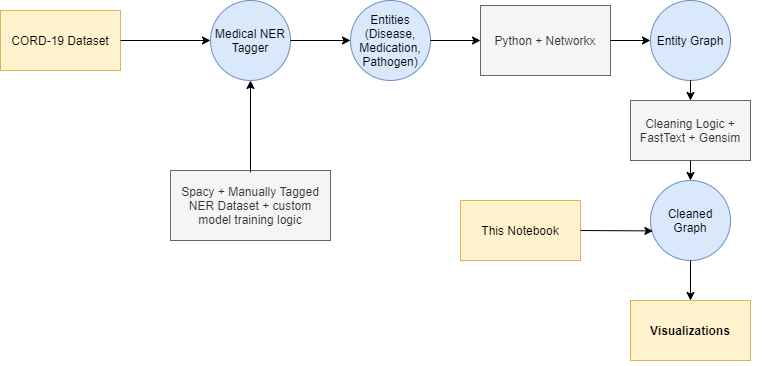

The plan was to use NER to find mentions diseases (medical condition), medication and pathogens in every paper. Then I created a graph using this information. Each of the above entities constitute the nodes of the graph. Everytime a (medical_condition,medication) or (medical_condition,pathogen) pair is encountered in a document a node is added to the graph.

Because of the small training data which I had for training a custom NER tagger, I had to add a cleansing step to remove wrongly identified entities. I used FastText's world embeddings along with a very simple thresholding based scheme. For every NER category, I picked 5 representataive entities. Then for every detected entity, I calculated average of similarity between the detected entity and each of five entitiy. Using a hard threshold I managed to eliminiate many unwanted entities.

This notebook uses the cleaned graph for generating the above mentioned visualizations

# Links to notebooks

* [Training Custom NER Model](https://www.kaggle.com/finalepoch/medical-ner-using-spacy) 
* [Running Custom NER Model and creating entity graph](#)  (Coming soon)
* [Cleaning NER output using FastText and simple similarity measure](#) (Coming soon)

In [ ]:
import random
from pathlib import Path
import networkx as nx
import pickle

Load the 'cleaned graph' and remove all edges with weights less than 200, because we want to limit the data to be shown in visualization

In [ ]:
G = pickle.load(open('/kaggle/input/medica-negraph/graph.pkl', 'rb'))
all_edges = G.edges(data=True)
edges_to_remove = [edge for edge in all_edges if edge[2]['weight'] < 150]
print(len(G.edges()),len(edges_to_remove))
G.remove_edges_from(edges_to_remove)
nodes_to_remove = [node[0] for node in G.nodes(data=True) if node[1]['weight'] < 100 ]
#nodes_to_remove = [node[0] for node in G.nodes(data=True) if '|' in node[0] ]
G.remove_nodes_from(nodes_to_remove)
G.remove_nodes_from(list(nx.isolates(G)))
print(len(G),len(G.edges()))

In [ ]:
def get_top_n_nodes(num):
    nodes_to_keep = []
    for t in ['MedicalCondition','Pathogen','Medicine']:
        mc_nodes = [(n[0],n[1]['weight']) for n in G.nodes(data=True) if n[1]['type'] == t]
        sorted_entities = sorted(mc_nodes, key=lambda tup: tup[1])
        sorted_entities.reverse()
        nodes_to_keep.extend([n[0] for n in sorted_entities[0:num]])
    return nodes_to_keep

This method takes medical condition (disease name) as input and returns top-n pathogens and treatments(medicines) linked to the medical condition. The 'path_n' tells the function max pathogens to fetch and 'treat_n' max medicine names to fetch

In [ ]:
def get_top_pathogen_and_treatment(med_condition,path_n,treat_n):
    try:
        neighbors = G.neighbors(med_condition)
        all_nodes = G.nodes[med_condition]
        pathogens = [(n,G.nodes[n]['weight']) for n in neighbors  if G.nodes[n]['type'] == 'Pathogen' and "vaccine" not in n]
        pathogen_weights = []
        for p in pathogens:
            pathogen_weights.append((p[0],G.edges[p[0],med_condition]['weight']))
        sorted_pathogens = sorted(pathogen_weights, key=lambda tup: tup[1])
        sorted_pathogens.reverse() 
        neighbors = G.neighbors(med_condition)
        medicines = [(n,G.nodes[n]['weight']) for n in neighbors  if G.nodes[n]['type'] == 'Medicine' 
                     and 'virus' not in n and "|" not in n]     
        medicine_weights = []
        for p in medicines:
            medicine_weights.append((p[0],G.edges[p[0],med_condition]['weight']))
        sorted_medicines = sorted(medicine_weights, key=lambda tup: tup[1])
        sorted_medicines.reverse()
        return (sorted_pathogens[0:path_n],sorted_medicines[0:treat_n])
    except:
        return([],[])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import logging
import warnings
import json
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

In [ ]:
top_nodes = get_top_n_nodes(40)
arr_ui = []
for node in top_nodes:
    if node[0:3] == 'MC_':
        #print(node)
        path,meds = get_top_pathogen_and_treatment(node,4,4)
        #print(path,meds)
        arr_ui.append([node[3:],
                       ", ".join([p[0][3:] for p in path]),
                       ", ".join([m[0][3:] for m in meds])])

In [ ]:
html_text = '''
<script>arr={0};function run(){window.setTimeout(function(){var x=parseInt(Math.random()*arr.length); $("#a").text(arr[x][0]).hide().fadeIn(1000);$("#b").text(arr[x][1]).hide().fadeIn(1000);$("#c").text(arr[x][2]).hide().fadeIn(1000);console.log("dfsdsdfdsff");run()},4000)}run();</script> 
'''.replace("{0}",json.dumps(arr_ui))
#display(widgets.HTML(value=html_text))
#print(html_text)

This method plots a bar chart for pathogens and medicines associated with a medicial condition.
Inputs are name of the medical condition and two dictionaries which contain counts for pathogens and medicines

In [ ]:
def plot_data(condition,pathogens,medicines):    
    fig, (ax1, ax2) = plt.subplots(1,2);
    fig.set_size_inches(8.5, 4.5)

    path_name = [p[0][3:] for p in pathogens]
    count = [p[1] for p in pathogens]
    y_pos = np.arange(len(path_name))
    ax1.barh(y_pos, count, align='center');
    ax1.set_yticks(y_pos);
    ax1.set_yticklabels(path_name);
    ax1.invert_yaxis();
    ax1.set_xlabel('Pathogens');
    ax1.set_title('Top pathogens');
    
    med_name = [p[0][3:] for p in medicines]
    count2 = [p[1] for p in medicines]
    y_pos2 = np.arange(len(med_name))
    ax2.barh(y_pos2, count2, align='center',color='r');
    ax2.set_yticks(y_pos2);
    ax2.set_yticklabels(med_name);
    ax2.invert_yaxis();
    ax2.set_xlabel('Medication');
    ax2.set_title('Top medicines');
    fig.tight_layout();
    _ = plt.show();


Draws basic UI for looking up information about a medical condition

In [ ]:

wtxt = widgets.Text(
    value='Enter Medical Conditon',
    disabled=False
)

combo = widgets.Combobox(
    options=[n[0][3:] for n in G.nodes(data=True) if n[1]['type'] == 'MedicalCondition'
 and n[1]['weight'] > 100 and 'virus' not in n[0]],
    description='',
    layout={'width': '230px'},
    disabled=False,
    placeholder = 'eg. headache,asthama'
)
btn = widgets.Button(
    description='Search',
    disabled=False,
    button_style='info',
    tooltip='Click me',
    icon='search' 
)


def on_change(change):
    clear_output()
    display(widgets.HBox((widgets.Label(value="Enter a medical condition and click search"),combo,btn)))
    a,b = get_top_pathogen_and_treatment("MC_"+combo.value,15,15)
    #print(a,b)
    newText = combo.value
    if len(a) > 0 or len(b) > 0:
        plot_data(combo.value,a,b)
    else:
        clear_output()
        info_section.value =  "<div>" + "no data found for <strong> " +combo.value + "</strong></div>"        
        display(widgets.HBox((form_anchor,widgets.Label(value="Enter a medical condition and click search"),combo,btn,info_section)))
        
btn.on_click(on_change)
form_anchor  = widgets.HTML(value="<span id='searchFrm'></span>")
info_section = widgets.HTML(value="<span></span>")

display(widgets.HBox((form_anchor,widgets.Label(value="Enter a medical condition and click search"),combo,btn,info_section)))

In [ ]:
G = pickle.load(open('/kaggle/input/medica-negraph/graph.pkl', 'rb'))
G = G.subgraph(get_top_n_nodes(30))
nx.write_gexf(G,'graph4_30.gexf')

In [ ]:
labels = [n for n in G.nodes()]
source,target,values = [],[],[]
for e in G.edges(data=True):
    if G.nodes[e[0]]['type'] == 'MedicalCondition':
        target.append(labels.index(e[1]))
        source.append(labels.index(e[0]))
    else:
        target.append(labels.index(e[0]))
        source.append(labels.index(e[1]))
    values.append(e[2]['weight'])
    
types_of_node = list(nx.get_node_attributes(G,'type').values())
 
for i in range(0,len(types_of_node)):
    if types_of_node[i] == 'Medicine':
        labels[i] = labels[i]+ ' ^'

In [ ]:
import plotly.graph_objects as go
import plotly
%matplotlib inline
plotly.offline.init_notebook_mode()

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 50,
      line = dict(color = "#dddddd", width = 0.5),
      label = [l[3:] for l in labels] ,
    ),
    link = dict(
      source = source, 
      target = target, 
      value = values 
  ))])

fig.update_layout(title_text="Relationship between diseases, pathongens and medication^", font_size=10,height=1000)
display(widgets.HTML(value="<span id='dataViz'></span>"))
fig.show()
plotly.offline.plot(fig, filename='relation.html')

[Open this visualization in a seperate tab of your browser](relation.html)